# Initialisation

In [1]:
#--------------- Importing key libraries and modules ---------------#
import time
from datetime import datetime, timedelta

import numpy as np
import scipy as spy
import scipy.constants as con
import math
from scipy.interpolate import interp1d
from uncertainties import ufloat # for managing errors in the data
from uncertainties import unumpy
from uncertainties.umath import * # for mathematical operations, e.g. unumpy.sin(x)

import speasy as spz
import SerPyShock as SP
import data_functions as data_func
import calc_functions as calc_func
import shock_functions as shock_func
import rankine_functions as RH  

import json
import pandas as pd
import import_ipynb

import matplotlib.pyplot as plt
%matplotlib widget

In [2]:
# Importing speasy databases
amda_tree = spz.inventories.tree.amda
cda_tree = spz.inventories.tree.cda
ssc_tree = spz.inventories.tree.ssc

## Input Satellite Data

In [3]:
#--------------- Input date and time of the shock, and the period of analysis before and after ---------------#

# Date of the shock
date = ['06', '05', '2015'] # DD-MM-YYYY format

# Time of the shock in the solar wind
t1 = ['00', '55', '00'] # HH:MM:SS format

# Time of the shock in the magnetosheath
t2 = ['01', '40', '40']

# Name of the spacecraft in the magnetosheath and solar wind, i.e. THEMIS cluster, WIND
name_spacecraft_msh = "THE"
name_spacecraft_sw = "WIND"

# Minutes observed before and after the shock in SW and MSH
time_obs = 20 # mins

start_date_sw, end_date_sw, time_shock_sw = data_func.find_time(date, t1, time_obs)
start_date_msh, end_date_msh, time_shock_msh = data_func.find_time(date, t2, time_obs)

shock_in_sw = (start_date_sw, end_date_sw, time_shock_sw)
shock_in_msh = (start_date_msh, end_date_msh, time_shock_msh)

### Json management

In [4]:
# The name of the json file to create/save the data in
name_file = 'data_shock.json'

# Formatting the date for json file
shock_date_json = date[0] +'/'+ date[1] +'/'+ date[2]

# Formatting the time for json file
shock_t1_json = [int(t1[0]), int(t1[1]), int(t1[2])]

# Formatting the time for json file
shock_t2_json = [int(t2[0]), int(t2[1]), int(t2[2])]

# Index of the shock for json file
index = '15'

### Windows

In [5]:
# Change the value for the averaging windows
up_shk_off = timedelta(minutes = 5)
dw_shk_off = timedelta(minutes = 5)
min_up_dur = timedelta(minutes = 3)
max_up_dur = timedelta(minutes = 10)
min_dw_dur = timedelta(minutes = 3)
max_dw_dur = timedelta(minutes = 10)
tcad = timedelta(seconds = 10)

In [6]:
def analyse_shock(location, name_spacecraft, start_date, end_date, time_shock, avg_windows):
    print("Analysing a shock in the",location,"\n")
    # Find the coordinates of the satellite
    coord = data_func.get_coordinate(name_spacecraft, time_shock)[0]
    
    # Retrives the plasma parameters
    print("Data Retrieved:")
    time_mag, B, B_unit, vec_B_up, vec_B_dw = shock_func.one_window_mag(name_spacecraft, start_date, end_date, avg_windows)
    time_vel, V, V_unit, vec_V_up, vec_V_dw = shock_func.one_window_vel(name_spacecraft, start_date, end_date, avg_windows)
    time_rho, rho, rho_unit, density_up, density_dw = shock_func.one_window_den(name_spacecraft, start_date, end_date, avg_windows)
    time_pres, temp, temp_unit, pres_up, pres_dw = shock_func.one_window_temp(name_spacecraft, start_date, end_date, avg_windows, rho)
    
    Rho = np.array([Density[0] for Density in rho])
    
    # Variable defined for the multiple averaging windows
    datetime_objects = pd.to_datetime(time_mag)
    freq = 'ns'
    datetime_index = pd.DatetimeIndex(datetime_objects).floor(freq)
    
    # Extends/interpolates the data to match precision of B
    interpolated_data_V, extended_rho_reshaped = shock_func.extend_data(B, V, rho)
    
    method_names = ["MC", "MX1", "MX2", "MX3", "VC"] # Names for printing
    """
    # Calculates the shock normal and speed for one window
    print("Analysing with one averaging window:\n")
    shock_func.one_window_shock_speed(vec_B_up, vec_B_dw, vec_V_up, vec_V_dw, density_up, density_dw, method_names)
    shock_func.SP_one_window(vec_B_up, vec_B_dw, vec_V_up, vec_V_dw)
    """
    avg_normals, avg_speeds = shock_func.SP_multiple_windows(datetime_index, B, interpolated_data_V, extended_rho_reshaped, time_shock, up_shk_off, dw_shk_off, min_up_dur, max_up_dur, min_dw_dur, max_dw_dur, tcad, method_names)
    """
    RH.rankine_methods(vec_B_up, vec_B_dw, B_unit, vec_V_up, vec_V_dw, V_unit, density_up, density_dw, rho_unit, pres_up, pres_dw, avg_normals, avg_speeds, method_names)
    """
    return time_mag, B, B_unit, time_vel, V, V_unit, time_rho, rho, rho_unit, Rho

In [7]:
#--------------- Defining the variables for multiple averaging windows ---------------#

# Choosing our shock time and satellite
name_spacecraft = name_spacecraft_sw
(start_date, end_date, time_shock) = shock_in_sw

# Defining ranges used in plotting (and for analysing one particular window)

up_shk_sw = time_shock - up_shk_off
dw_shk_sw = time_shock + dw_shk_off

# Define the list of time up and down for our averaging range
window_up_sw = (time_shock - max_up_dur, up_shk_sw)
window_dw_sw = (dw_shk_sw, time_shock + max_dw_dur)
windows = (window_up_sw, window_dw_sw)

# Define variable to plot the minimum and maximum windows
up_windows_sw = (up_shk_sw - min_up_dur, up_shk_sw - max_up_dur)
dw_windows_sw = (dw_shk_sw + min_dw_dur, dw_shk_sw + max_dw_dur)

In [8]:
time_mag_sw, B_sw, B_unit_sw, time_vel_sw, V_sw, V_unit_sw, time_rho_sw, rho_sw, rho_unit_sw, Rho_sw = analyse_shock("Solar Wind", name_spacecraft, start_date, end_date, time_shock, windows)

Analysing a shock in the Solar Wind 

The time is: ['2015-05-06T00:50:00.000000000']
The satellite coordinate are: [[237.92738659 -91.97729899  13.63589939]]


Data Retrieved:
Upstream Magnetic Field: [-0.1, 5.45, 2.2] ± [0.7, 0.21, 0.5] nT
Downstream Magnetic Field: [-2.6, 11.5, 4.5] ± [0.9, 2.2, 2.9] nT

Upstream Velocity: [-382.8, -30.7, -10.0] ± [2.5, 3.4, 4.0] km/s
Downstream Velocity: [-453.0, -47.4, -23.0] ± [5.0, 0.6, 4.0] km/s

Upstream Density: 4.6±0.4 cm-3
Downstream Density: 12.4±0.7 cm-3

Upstream Pressure: 0.00145±0.00028 nPa
Downstream Pressure: 0.0126±0.0010 nPa


Trotta - Multiple Averaging Windows:

Method MC
Normal: [-0.86, -0.25, -0.38] ± [0.05, 0.1, 0.21] 
Angle: 68.0±2.6 
Shock Speed: 461±4 km/s

Method MX1
Normal: [-0.932, -0.315, -0.174] ± [0.01, 0.02, 0.024] 
Angle: 69.2±2.8 
Shock Speed: 496±4 km/s

Method MX2
Normal: [-0.933, -0.316, -0.173] ± [0.01, 0.019, 0.024] 
Angle: 69.3±2.8 
Shock Speed: 496±4 km/s

Method MX3
Normal: [-0.933, -0.316, -0.172] ± [0.01, 

In [9]:
#--------------- Defining the variables for multiple averaging windows ---------------#

# Choosing our shock time and satellite
name_spacecraft = name_spacecraft_msh
(start_date, end_date, time_shock) = shock_in_msh

# Defining ranges used in plotting (and for analysing one particular window)

up_shk_msh = time_shock - up_shk_off
dw_shk_msh = time_shock + dw_shk_off

# Define the list of time up and down for our averaging range
window_up_msh = (time_shock - max_up_dur, up_shk_msh)
window_dw_msh = (dw_shk_msh, time_shock + max_dw_dur)
windows = (window_up_msh, window_dw_msh)

# Define variable to plot the minimum and maximum windows
up_windows_msh = (up_shk_msh - min_up_dur, up_shk_msh - max_up_dur)
dw_windows_msh = (dw_shk_msh + min_dw_dur, dw_shk_msh + max_dw_dur)

In [10]:
time_mag_msh, B_msh, B_unit_msh, time_vel_msh, V_msh, V_unit_msh, time_rho_msh, rho_msh, rho_unit_msh, Rho_msh = analyse_shock("Magnetosheath", name_spacecraft, start_date, end_date, time_shock, windows)

Analysing a shock in the Magnetosheath 

The time is: ['2015-05-06T01:36:00.000000000' '2015-05-06T01:37:00.000000000'
 '2015-05-06T01:38:00.000000000' '2015-05-06T01:39:00.000000000'
 '2015-05-06T01:40:00.000000000' '2015-05-06T01:41:00.000000000'
 '2015-05-06T01:42:00.000000000' '2015-05-06T01:43:00.000000000'
 '2015-05-06T01:44:00.000000000' '2015-05-06T01:45:00.000000000']
The satellite coordinate are: [[11.5978   1.95457 -2.10752]
 [11.5929   1.96236 -2.10913]
 [11.5881   1.97014 -2.11073]
 [11.5832   1.97791 -2.11232]
 [11.5783   1.98567 -2.11391]
 [11.5733   1.99343 -2.11549]
 [11.5683   2.00118 -2.11706]
 [11.5632   2.00893 -2.11863]
 [11.5582   2.01667 -2.12019]
 [11.553    2.0244  -2.12174]]


Data Retrieved:
Upstream Magnetic Field: [-1.4, 31.0, 24.0] ± [1.5, 4.0, 4.0] nT
Downstream Magnetic Field: [-5.8, 40.0, 7.0] ± [2.7, 4.0, 12.0] nT

Upstream Velocity: [-22.0, 56.0, -40.0] ± [8.0, 19.0, 15.0] km/s
Downstream Velocity: [-126.0, 39.0, -35.0] ± [22.0, 11.0, 22.0] km/s

Ups

# Plotting Graph of Shock Parameters in SW and MSH

In [11]:
# --------------- function to plot the line and windows time ----------------
def plot_line(window_up,time_down,up_windows,dw_windows, up_shk, dw_shk, time_shock,ax):
    #------ averaging window for our calculation ------
    ax.axvspan(window_up[0],window_up[1], facecolor = "grey", alpha = 1)
    ax.axvspan(time_down[0],time_down[1], facecolor = "grey", alpha = 1)

    #------ averaging windows for the Trotta code -----
    ax.axvspan(up_shk, up_windows[0], facecolor = "green", alpha = 0.6)
    ax.axvspan(up_shk, up_windows[1], facecolor = "green", alpha = 0.3)
    ax.axvspan(dw_shk,dw_windows[0], facecolor = "yellow", alpha = 0.6)
    ax.axvspan(dw_shk,dw_windows[1], facecolor = "yellow", alpha = 0.3)
    ax.axvline(x = time_shock, color = "black")

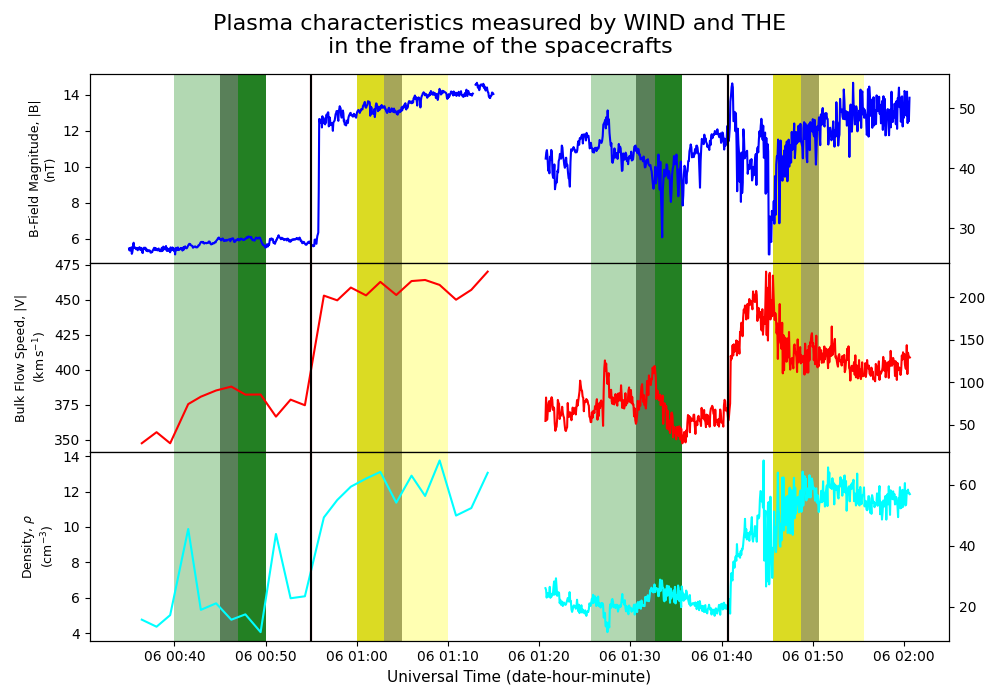

In [12]:
#--------------- plot of SW ---------------

fig = plt.figure(figsize=(10, 7))
gs = fig.add_gridspec(3, hspace=0)
axes = gs.subplots(sharex=True, sharey=False)

plt.xlabel('Universal Time (date-hour-minute)',fontsize = 11)

axes[0].plot(time_mag_sw, [calc_func.magnitude(lst) for lst in B_sw], color='blue', label = '|B|')
axes[0].axvline(time_shock_sw, c = 'red')
axes[0].set_ylabel('B-Field Magnitude, |B|\n(nT)', fontsize = 9)
plot_line(window_up_sw,window_dw_sw,up_windows_sw,dw_windows_sw, up_shk_sw, dw_shk_sw,time_shock_sw,ax=axes[0])

axes[1].plot(time_vel_sw, [calc_func.magnitude(lst) for lst in V_sw], color='red', label = '|V|')
axes[1].axvline(time_shock_sw, c = 'red')
axes[1].set_ylabel('Bulk Flow Speed, |V|\n'+r'($\mathrm{km\,s^{-1}}$)', fontsize = 9)
plot_line(window_up_sw,window_dw_sw,up_windows_sw,dw_windows_sw, up_shk_sw, dw_shk_sw,time_shock_sw,ax=axes[1])

axes[2].plot(time_rho_sw, Rho_sw, color='cyan', label = r'$\rho$')
axes[2].axvline(time_shock_sw, c = 'red')
axes[2].set_ylabel('Density, '+r'$\rho$'+'\n'+r'($\mathrm{cm^{-3}}$)', fontsize = 9)
plot_line(window_up_sw,window_dw_sw,up_windows_sw,dw_windows_sw, up_shk_sw, dw_shk_sw,time_shock_sw,ax=axes[2])

fig.suptitle(f'Plasma characteristics measured by: {name_spacecraft_sw}', fontsize = 16)
plt.tight_layout()


#--------------- plot of MSH ---------------

ax_0 = axes[0].twinx()
ax_0.plot(time_mag_msh, [calc_func.magnitude(lst) for lst in B_msh], color='blue', label = '|B|')
ax_0.axvline(time_shock_msh, c = 'red')
plot_line(window_up_msh,window_dw_msh,up_windows_msh,dw_windows_msh, up_shk_msh, dw_shk_msh,time_shock_msh,ax_0)

ax_1 = axes[1].twinx()
ax_1.plot(time_vel_msh, [calc_func.magnitude(lst) for lst in V_msh], color='red', label = '|V|')
ax_1.axvline(time_shock_msh, c = 'red')
plot_line(window_up_msh,window_dw_msh,up_windows_msh,dw_windows_msh, up_shk_msh, dw_shk_msh,time_shock_msh,ax_1)

ax_2 = axes[2].twinx()
ax_2.plot(time_rho_msh, Rho_msh, color='cyan', label = r'$\rho$')
ax_2.axvline(time_shock_msh, c = 'red')
plot_line(window_up_msh,window_dw_msh,up_windows_msh,dw_windows_msh, up_shk_msh, dw_shk_msh,time_shock_msh,ax_2)

fig.suptitle(f'Plasma characteristics measured by {name_spacecraft_sw} and {name_spacecraft_msh}\nin the frame of the spacecrafts', fontsize = 16)
plt.tight_layout()
#plt.close()